# **5. Transfer learning with VGG-19**

So far, we have created a CNN from scratch and tried to improve it as much as possible so that we could get a high enough accuracy in both training and testing datasets. 

Our next step is trying to use the power of pre-trained networks and apply them to our problem, a technique most commonly known as transfer learning. In this notebook, we will apply transfer learning using a popular neural network called [VGG19](https://arxiv.org/abs/1409.1556). We will use the model for extracting features from the images in our dataset and training a fully-connected classifier on those features. 

# Introduction

## What is transfer learning?

When building a CNN to solve a classification problem, there are two common ways in which we can proceed:

1. Build a new model architecture from scratch.
2. Use the knowledge from a previously trained model and apply it to the current problem transfer.

Transfer learning involves applying the second methodology, in which we take a pre-trained neural network that has been trained on a large and diverse dataset and use the features it has extracted as a starting point for solving a new problem. 

There are several ways in which transfer learning can be applied:

1. Feature extraction: In this approach, the pre-trained model is used as a fixed feature extractor, and the extracted features are then used as input for training a classifier on the current problem. In this case, the weights of the pre-trained model are not updated during this training process (the model stays fully *frozen*), so it requires that the problem at hand is similar enough to the problem the pre-trained model was originally designed to solve.

2. Fine-tuning: In this case, the pre-trained model is combined with a new classifier on top of a new classifier and we unfreeze the last few layers of the convolutional part. This allows us to retain most of the network intact, keeping the general features in place and only allowing the model to learn some new, more specific features from our dataset. Although this will imply training the model (which is slower than using the classifier for feature extraction), it has the advantage of allowing us to adapt the pre-trained model to our problem. 

**Sources**

+ Brownlee, J. (2019) A gentle introduction to transfer learning for Deep learning, MachineLearningMastery.com. Available at: https://machinelearningmastery.com/transfer-learning-for-deep-learning/ (Accessed: April 2, 2023). 
+ Mwiti, D. (2023) Transfer learning guide: A practical tutorial with examples for images and text in Keras, neptune.ai. Available at: https://neptune.ai/blog/transfer-learning-guide-examples-for-images-and-text-in-keras (Accessed: April 2, 2023). 

In [1]:
# Base libraries
import os

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

# Tensorflow
import tensorflow.keras as keras
from tensorflow import debugging as tfdbg
from tensorflow import device
from tensorflow.keras import optimizers
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# VGG-19
from tensorflow.keras.applications import VGG19

# Own modules
from src.utils import drop_checkpoints, dataset_stats, plot_metric_curves, extract_features

2023-04-02 11:50:01.327626: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-04-02 11:50:01.327708: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-04-02 11:50:01.327716: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


Now let's see how our data is structured:

In [2]:
# Root folder
base_dir = "./data"

In [3]:
# Train folder
train_dir = os.path.join(base_dir, "train")

# Validation folder
validation_dir = os.path.join(base_dir, "validation")

# Test folder
test_dir = os.path.join(base_dir, "test")

In [4]:
drop_checkpoints(base_dir)

Let's also see how many images there are for each class in the training, validation and test set.

In [5]:
dataset_stats(train_dir, validation_dir, test_dir)

Number of classes: 4
Existing classes: ['Renaissance', 'Realism', 'Baroque', 'Romanticism']

----------------------------------------
Number of images per class and dataset:
----------------------------------------
             Train  Validation  Test
Style                               
Renaissance   4000         500   500
Realism       4000         500   500
Baroque       4000         500   500
Romanticism   4000         500   500


We'll also create the directory, if not created yet, where the models will be saved:

In [6]:
# Create directory where to save the models created
models_dir = "./models"
os.makedirs(models_dir, exist_ok=True)

# 5.1 Model structure

In [7]:
# Define some hyperparameters' values

# Input shape
input_shape = (224, 224,  3)

# Batch_size and steps per epoch
training_size = sum([len(file) for path, folder, file in os.walk(train_dir)])
batch_size = 128
steps_per_epoch = training_size // batch_size
print(f"Steps per epoch: {steps_per_epoch}")

Steps per epoch: 125


The first thing we will do is load the `VGG19` model, which is already included in the `keras` library. We will set `include_top=False` so that we can load just the convolutional part of the model, as we want to train our own DNN to perform the classification task. 

In [8]:
model = models.Sequential()

# initialize convolutional base for the model - based on VGG19
conv_base = VGG19(weights='imagenet',
                  include_top=False,
                  pooling=None,
                  input_shape=input_shape)

conv_base.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

We can now create our DNN classifier:

In [9]:
last_layer_shape = (7, 7, 512)
last_layer_size = last_layer_shape[0]*last_layer_shape[1]*last_layer_shape[2]

In [10]:
# Create the model
model = models.Sequential()

model.add(layers.Dense(256, activation='relu', input_dim=last_layer_size))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(128, activation='relu'))

# Output layer
model.add(layers.Dense(4, activation='softmax'))

In [11]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               6422784   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 4)                 516       
                                                                 
Total params: 6,456,196
Trainable params: 6,456,196
Non-trainable params: 0
_________________________________________________________________


We'll use Adam as our optimizer since it is the most popular optimizer right now, as well as versatile (i.e., it can be used in multiple contexts).

In [12]:
optimizer = optimizers.Adam(learning_rate=1e-4)

model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer,
    metrics=['acc']
)

# 5.2. Data preprocessing

In this case, we will include the Data Augmentation step to the model preprocessing step

In [13]:
# Apply data augmentation to the training set
# https://towardsdatascience.com/exploring-image-data-augmentation-with-keras-and-tensorflow-a8162d89b844
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=(0.8, 1),
    zoom_range=[0.9, 1.1],
    horizontal_flip=True,
    fill_mode='nearest'
    )

# The data augmentation must not be used for the test set!
# All images will be rescaled by 1./255
test_datagen = ImageDataGenerator(rescale=1./255)

In [14]:
train_generator = train_datagen.flow_from_directory(
        train_dir,
        # All images will be resized to the dimensions specified
        target_size=input_shape[:2],
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True
        )

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        # All images will be resized to the dimensions specified
        target_size=input_shape[:2],
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
        )

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=input_shape[:2],
        batch_size=40,
        class_mode='categorical',
        shuffle=False
)

Found 16000 images belonging to 4 classes.
Found 2000 images belonging to 4 classes.
Found 2000 images belonging to 4 classes.


We can now use `VGG19` to extract features from the images:

In [15]:
train_features, train_labels = extract_features(16000, last_layer_shape, conv_base, train_generator, batch_size)
validation_features, validation_labels = extract_features(2000, last_layer_shape, conv_base, validation_generator, batch_size)
test_features, test_labels = extract_features(2000, last_layer_shape, conv_base, test_generator, 40)

# Flatten features prior to feeding them to the classifier
train_features = np.reshape(train_features, (16000, last_layer_size))
validation_features = np.reshape(validation_features, (2000, last_layer_size))
test_features = np.reshape(test_features, (2000, last_layer_size))

4/4 [==============================] - 0s 148ms/step


/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:858: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


2/2 [==============================] - 0s 125ms/step


In [16]:
for data_batch, labels_batch in train_generator:
    print('Data batch shape:', data_batch.shape)
    print('Labels batch shape:', labels_batch.shape)
    break

Data batch shape: (128, 224, 224, 3)
Labels batch shape: (128, 4)


# 5.3. Training

Let's train the model.

In [17]:
# Model name and path
model_path = os.path.join("models", "vgg19_frozen_model.h5")

In [18]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint(model_path, monitor='val_loss', 
                     mode='min', verbose=1, save_best_only=True)

In [19]:
history = model.fit(
    train_features, train_labels,
    steps_per_epoch=steps_per_epoch,
    epochs=30,
    validation_data=(validation_features, validation_labels),
    validation_steps=20,
    callbacks = [es, mc]
)

Epoch 1/30
121/125 [============================>.] - ETA: 0s - loss: 1.2352 - acc: 0.4288
Epoch 1: val_loss improved from inf to 1.11412, saving model to models/vgg19_frozen_model.h5
125/125 [==============================] - 3s 12ms/step - loss: 1.2310 - acc: 0.4322 - val_loss: 1.1141 - val_acc: 0.5120
Epoch 2/30
119/125 [===========================>..] - ETA: 0s - loss: 1.0895 - acc: 0.5272
Epoch 2: val_loss improved from 1.11412 to 1.07009, saving model to models/vgg19_frozen_model.h5
125/125 [==============================] - 1s 9ms/step - loss: 1.0871 - acc: 0.5279 - val_loss: 1.0701 - val_acc: 0.5480
Epoch 3/30
121/125 [============================>.] - ETA: 0s - loss: 1.0263 - acc: 0.5605
Epoch 3: val_loss improved from 1.07009 to 1.05192, saving model to models/vgg19_frozen_model.h5
125/125 [==============================] - 1s 9ms/step - loss: 1.0255 - acc: 0.5613 - val_loss: 1.0519 - val_acc: 0.5550
Epoch 4/30
124/125 [============================>.] - ETA: 0s - loss: 0.9639

Now let's load the best model found:

In [20]:
# load the saved model
vgg19_model = load_model(model_path)

# 5.4. Validation

Let's plot how the loss and the accuracy from both training and validations sets have evolved during the training process. 

In [21]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

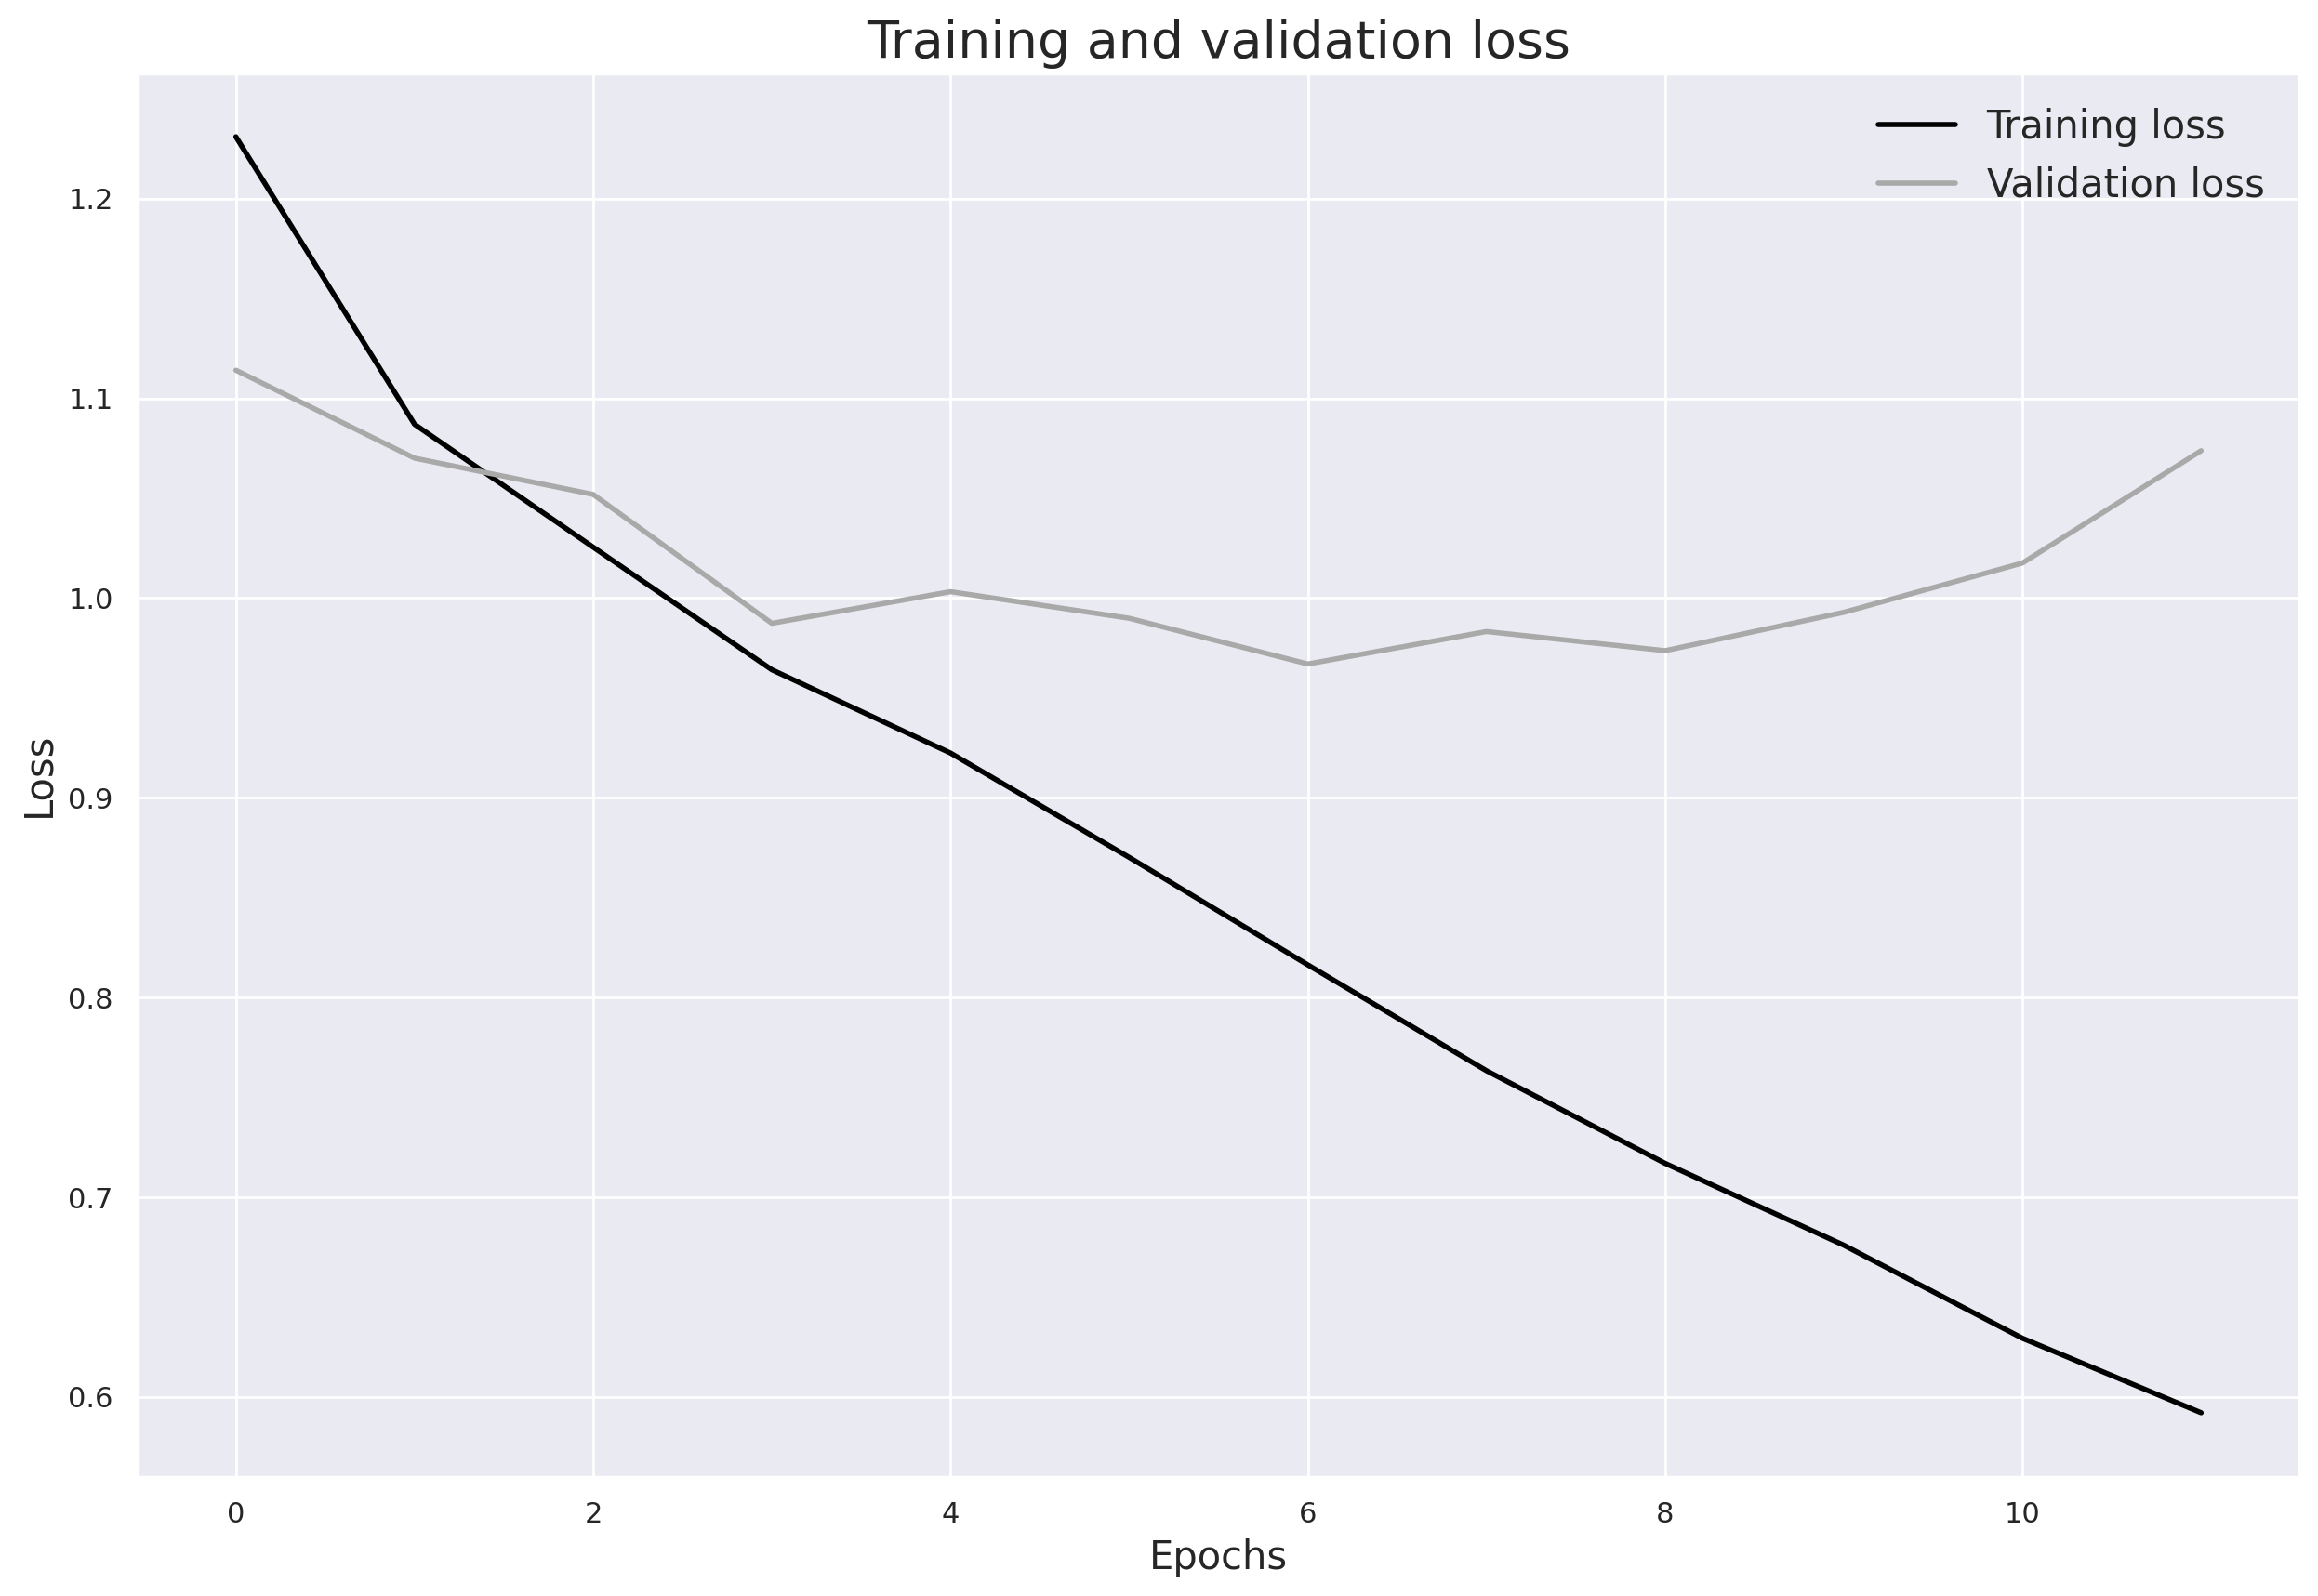

In [22]:
# Plot loss curves
plot_metric_curves(epochs, loss, val_loss, "black", "darkgray", "Loss")

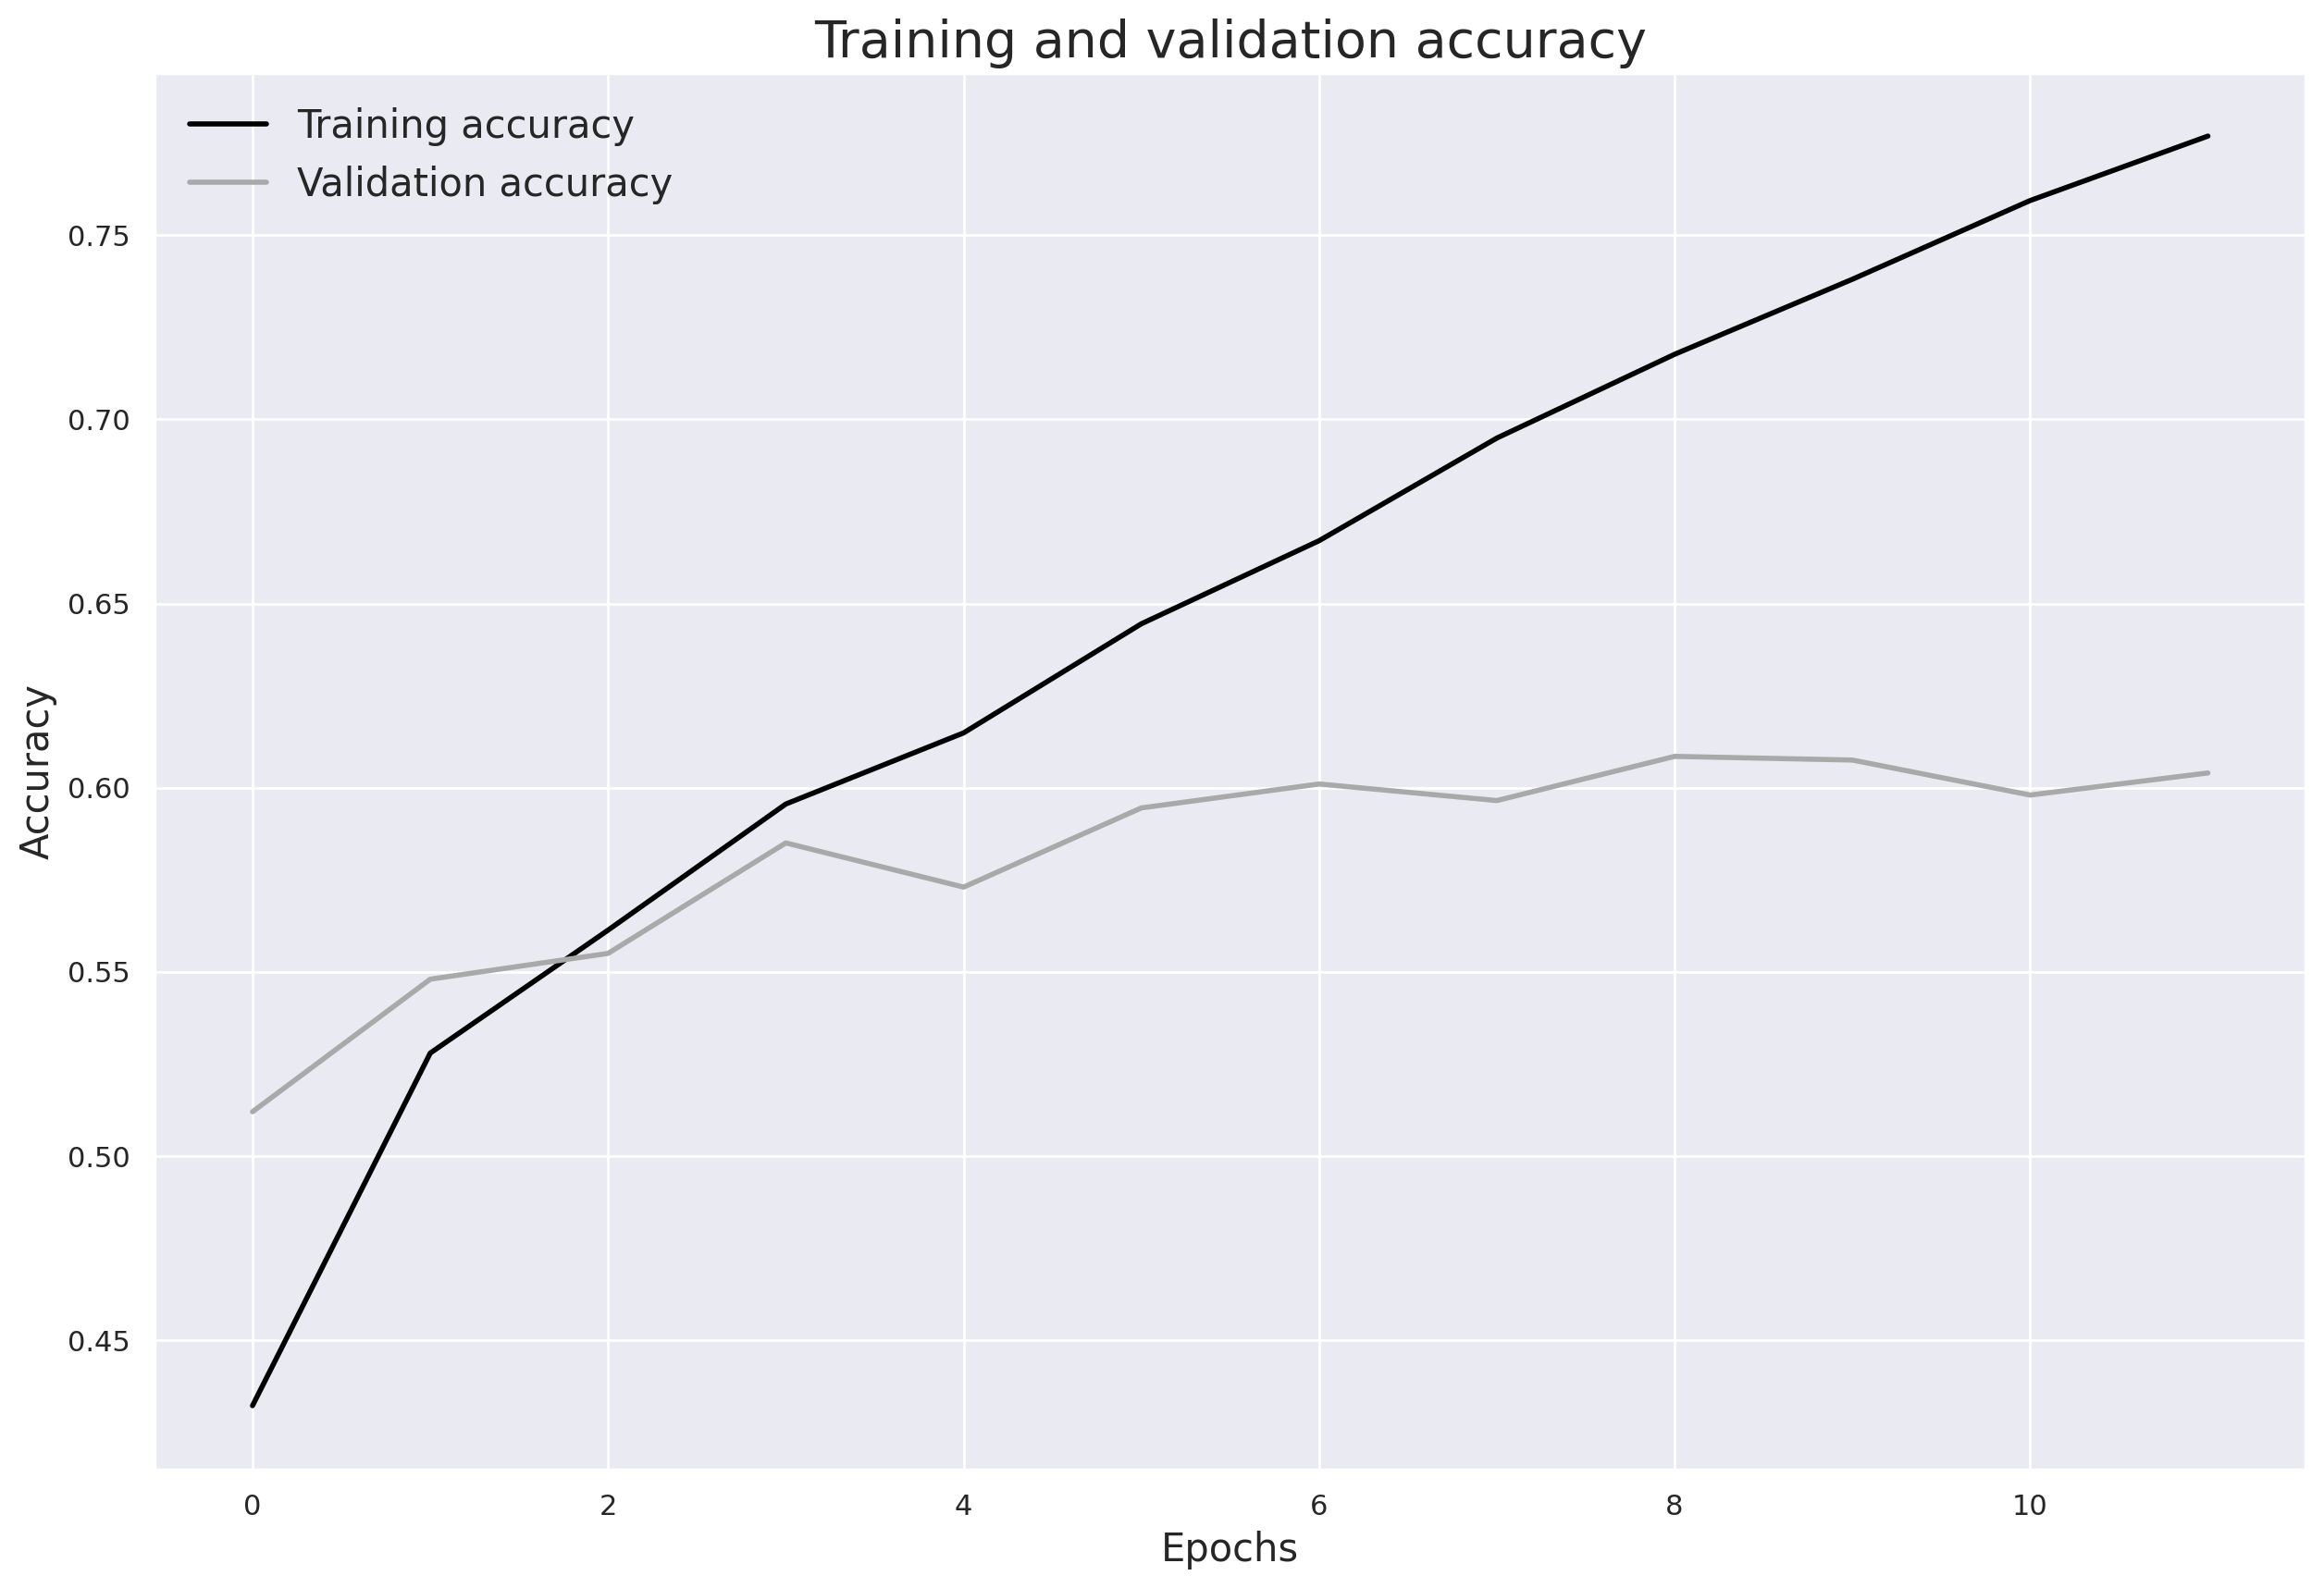

In [23]:
# Plot accuracy curves
plot_metric_curves(epochs, acc, val_acc, "black", "darkgray", "Accuracy")

In [25]:
vgg19_model.evaluate(test_features, test_labels)

63/63 [==============================] - 0s 3ms/step - loss: 0.9208 - acc: 0.6105


[0.9208182692527771, 0.6104999780654907]

As we can see in the above plots, peformance is fairly impressive for being such a simple classifier, with an accuracy of over 75% in training and around 60% in testing. However, the results are comparable to the ones we obtained in our made-from-scratch models, so the feature extraction is not enough for improving our prior performance benchmarks.